# Overview

In this notebook we examine data concerning malignant mesothelioma, a type of cancer that affects lining of the chest wall and lungs, and is mainly caused by asbestos exposure. The data set is a set of test results of patients with two different types of the cancer, and our goal is to create models that differentiate between each of them. Link to the original paper can be found <a href='http://www.sciencedirect.com/science/article/pii/S0045790611001261'>here</a> and data set can be found <a href='https://archive.ics.uci.edu/ml/datasets/Mesothelioma%C3%A2%E2%82%AC%E2%84%A2s+disease+data+set+#'>here</a>.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve


warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


%matplotlib inline

In [2]:
data = pd.read_csv('data.csv').drop('diagnosis method', axis=1)
print('{} patients, {} features'.format(*data.shape))
# diagnosis method dropped because it is a duplicate of class of diagnosis


# Initially class of diagonosis has two different values possible : 2 and 1
# specyfing which type of cancer patient has. In order to accomodate internal
# representation of binary data in pandas, we have to change it to 1's and 0's.
# This operation does not lose any information
data['class of diagnosis'] -= 1

324 patients, 34 features


# Checking for missing values

In [3]:
data.isnull().any()

age                                 False
gender                              False
city                                False
asbestos exposure                   False
type of MM                          False
duration of asbestos exposure       False
keep side                           False
cytology                            False
duration of symptoms                False
dyspnoea                            False
ache on chest                       False
weakness                            False
habit of cigarette                  False
performance status                  False
white blood                         False
cell count (WBC)                    False
hemoglobin (HGB)                    False
platelet count (PLT)                False
sedimentation                       False
blood lactic dehydrogenise (LDH)    False
alkaline phosphatise (ALP)          False
total protein                       False
albumin                             False
glucose                           

# Frequencies of categorical variables
Plotted in order to see whether there are any visible differences between classes of diagnosis.

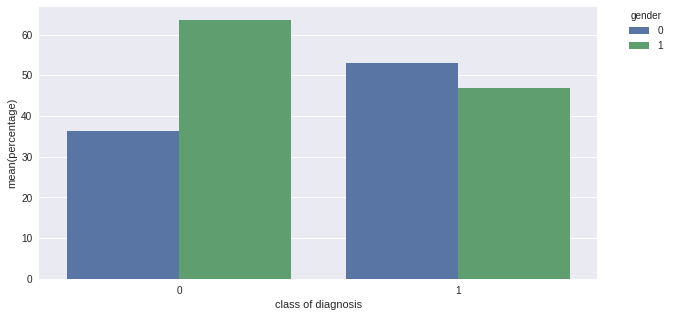

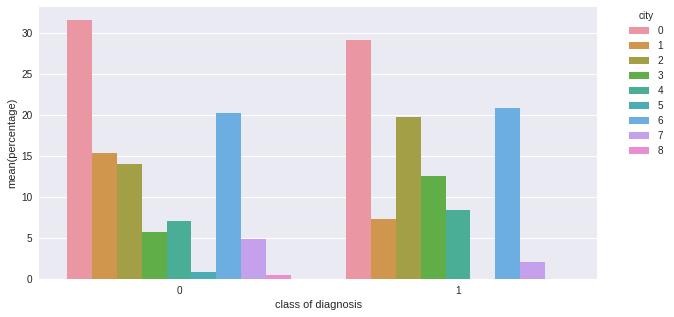

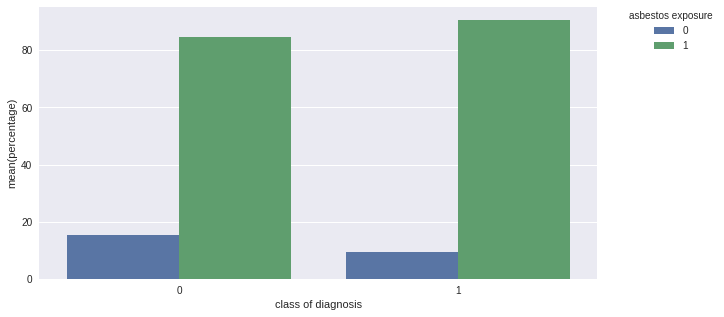

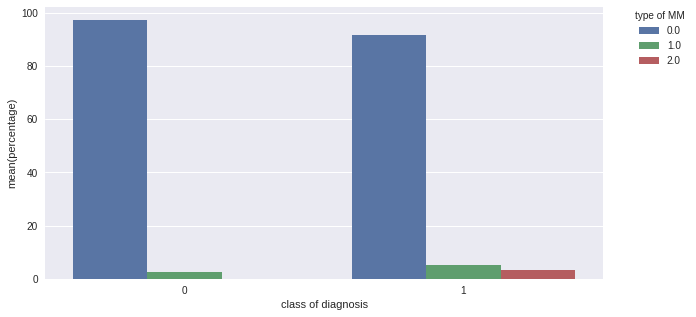

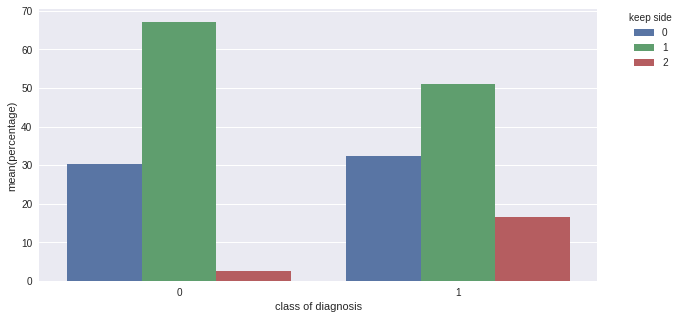

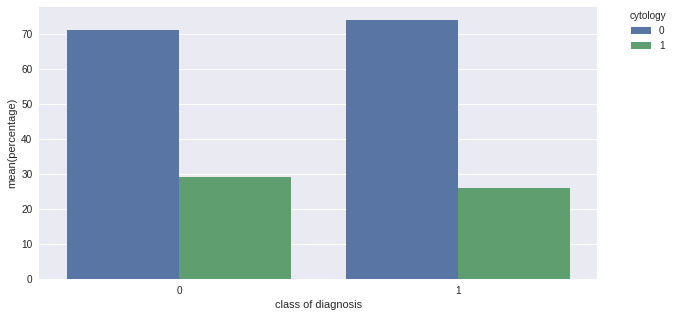

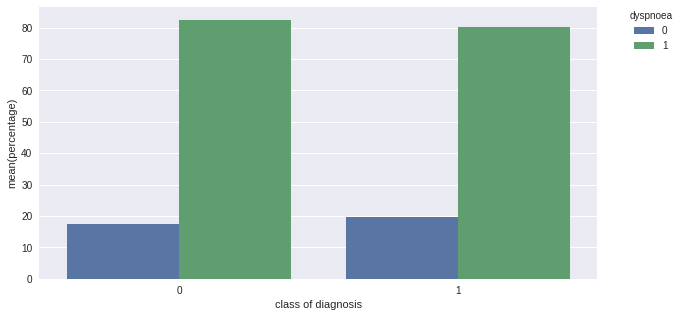

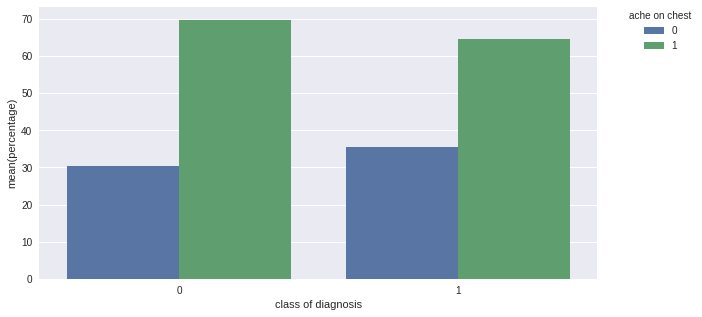

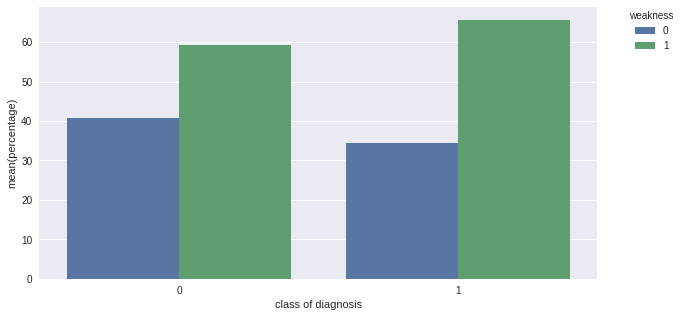

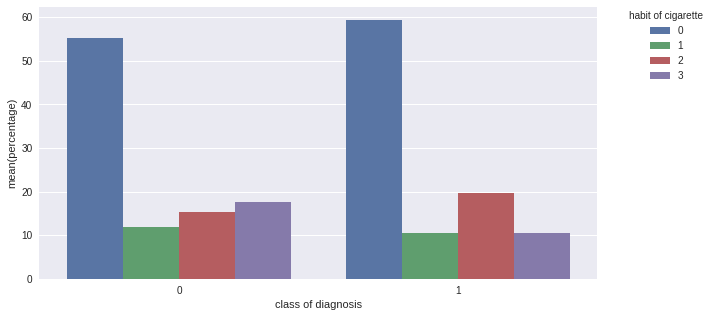

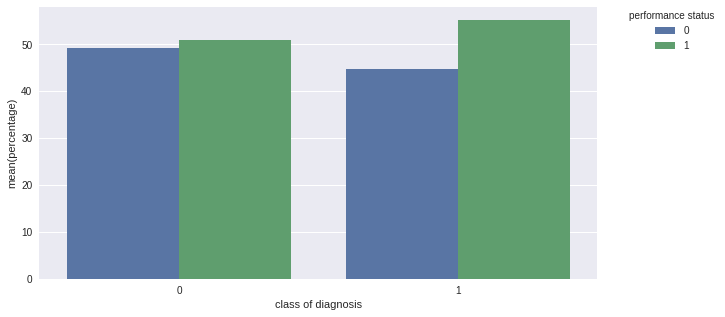

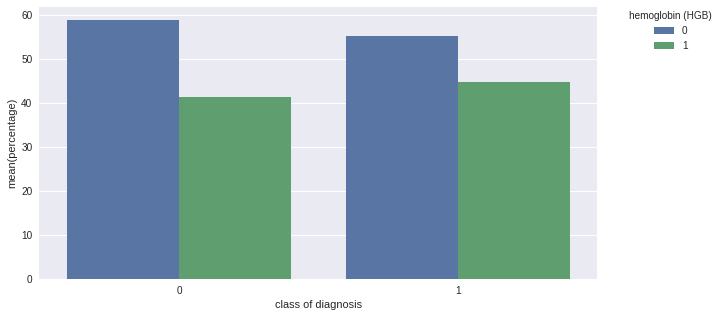

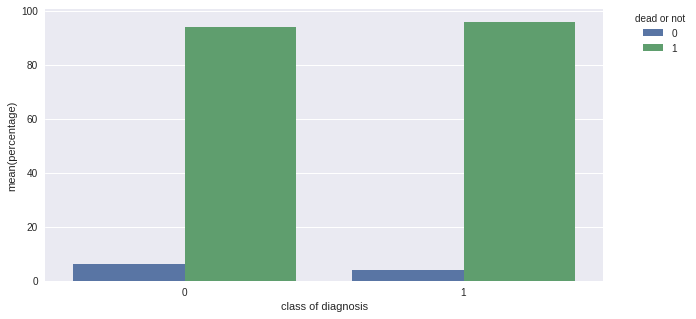

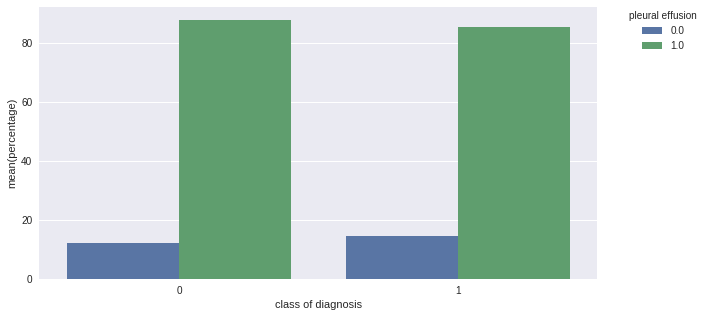

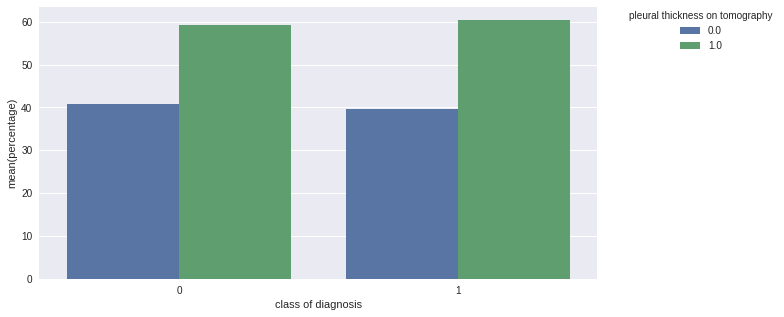

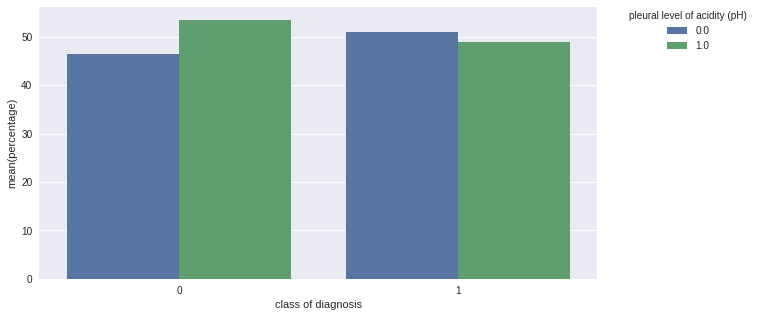

In [4]:
categoricals = data.ix[:, data.apply(lambda x: x.nunique()) < 10]
grouped = categoricals.groupby(['class of diagnosis'])
for col in categoricals.drop('class of diagnosis', axis=1):
    counts = (grouped[col]
              .value_counts(normalize=True)
              .rename('percentage')
              .mul(100)
              .reset_index())
    plt.figure(figsize=(10, 5))
    p = sns.barplot(x='class of diagnosis', y='percentage', hue=col,
                    data=counts)
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Distributions of continous variables

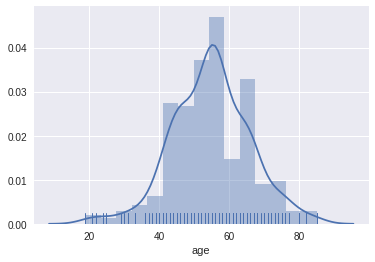

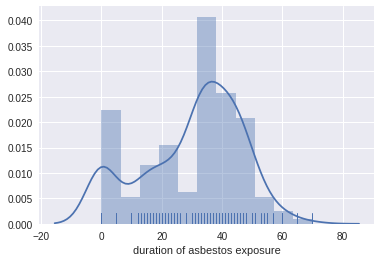

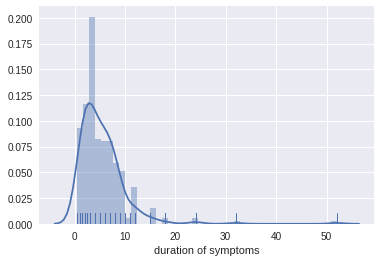

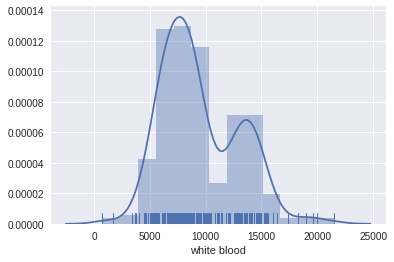

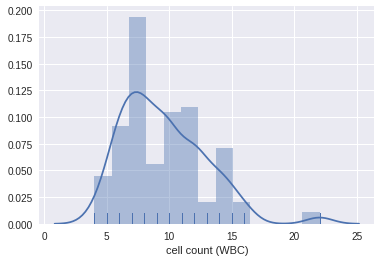

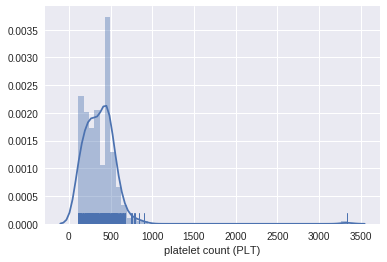

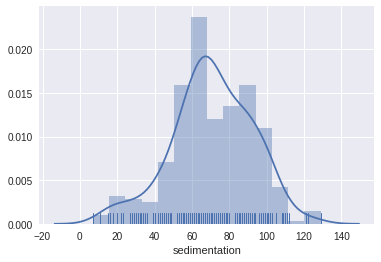

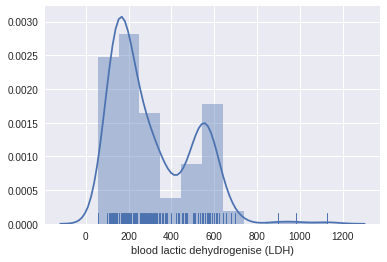

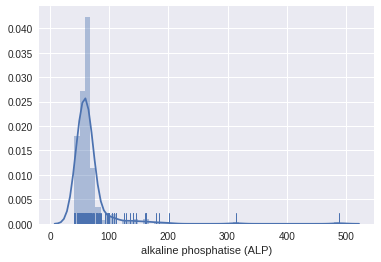

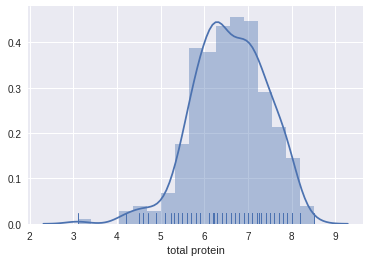

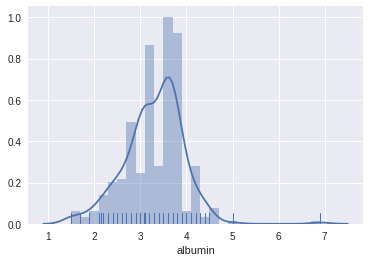

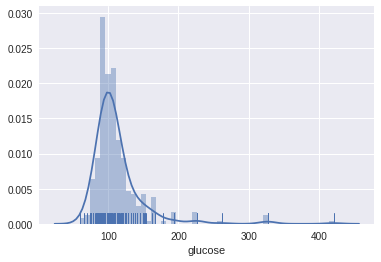

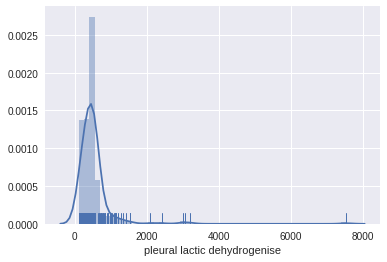

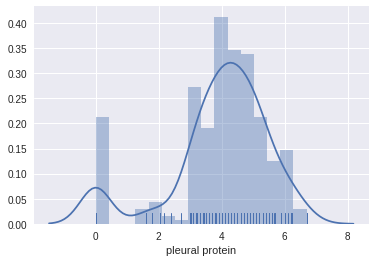

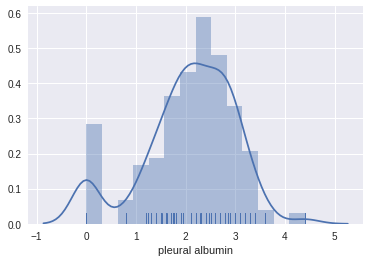

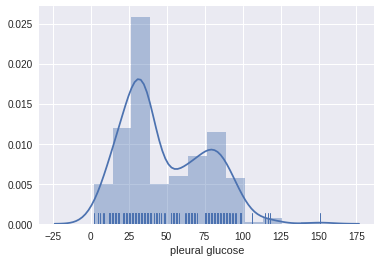

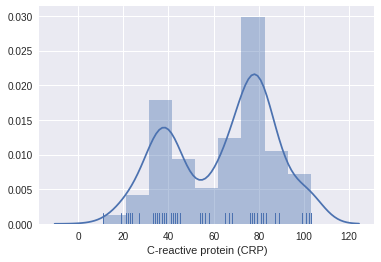

In [5]:
continuous = data.drop(categoricals.columns, axis=1)
for col in continuous:
    plt.figure()
    sns.distplot(continuous[col], rug=True)

# Distributions split by target values

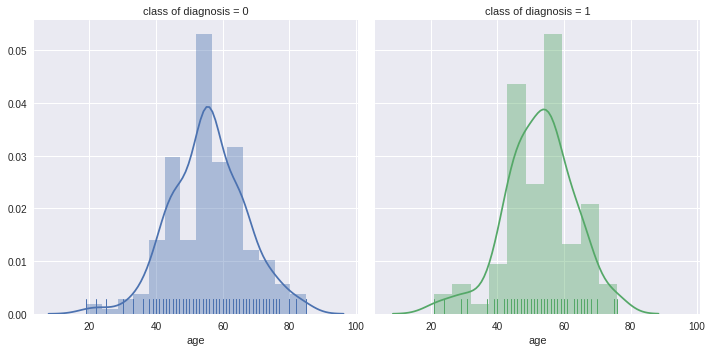

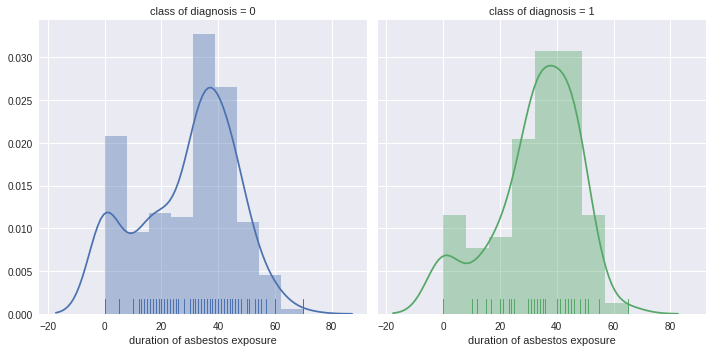

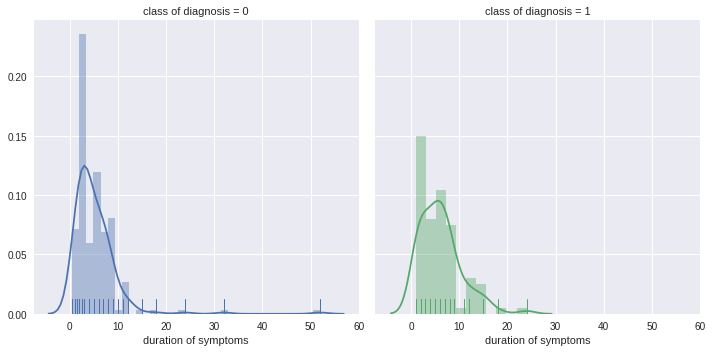

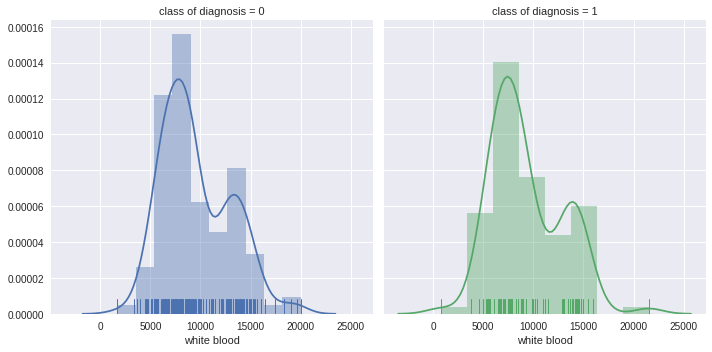

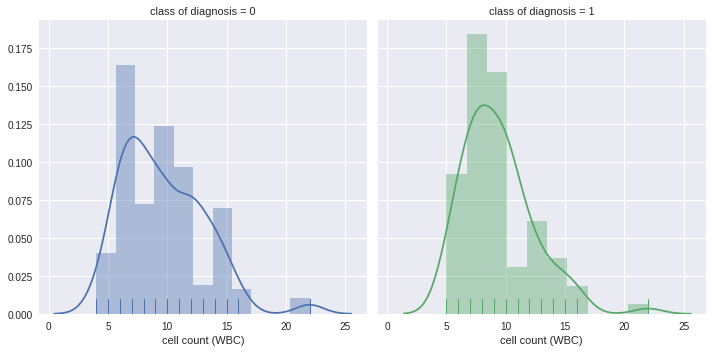

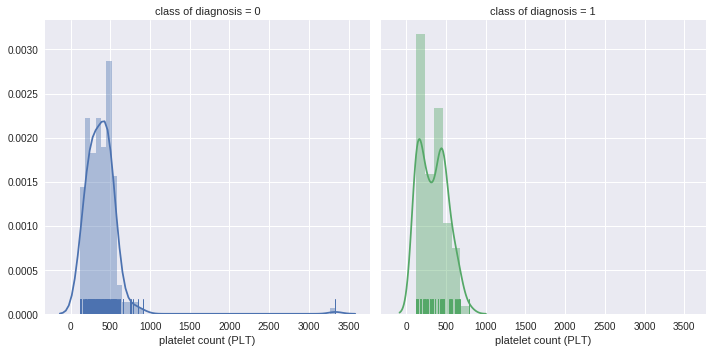

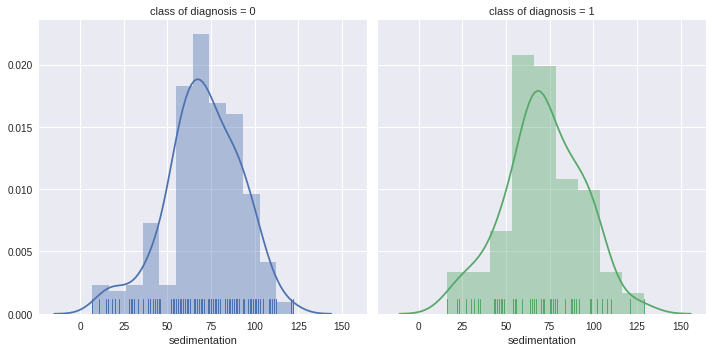

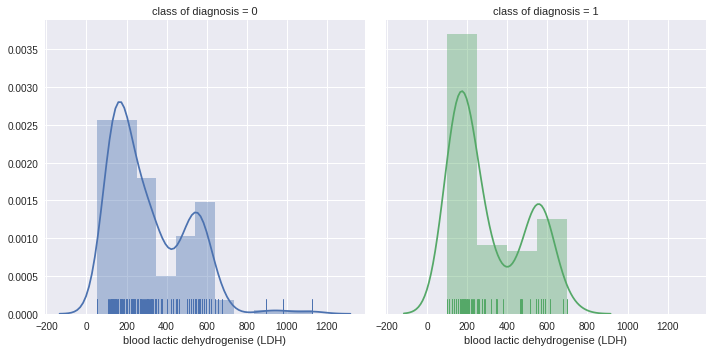

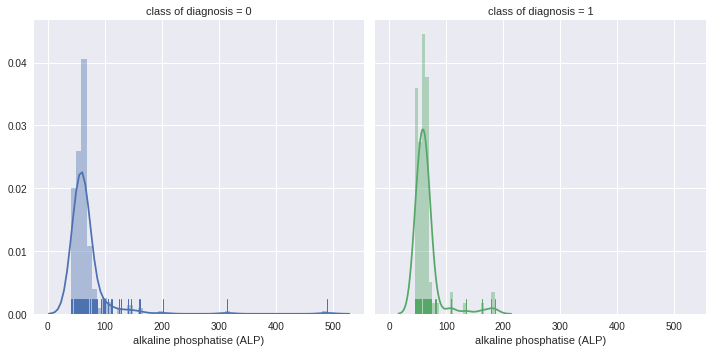

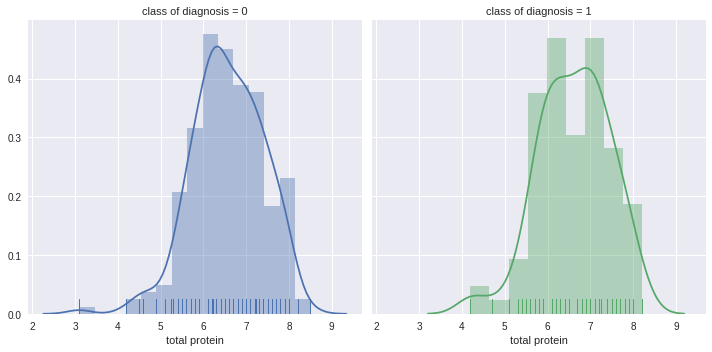

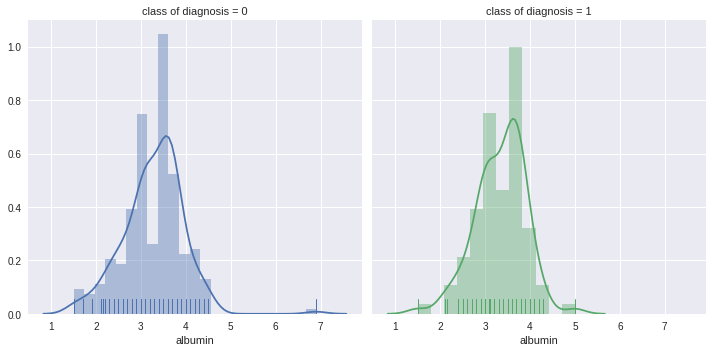

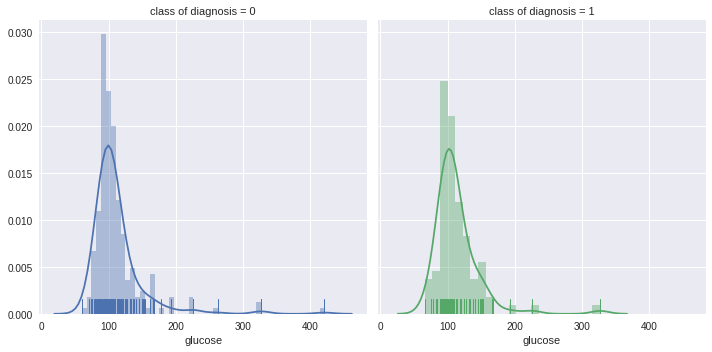

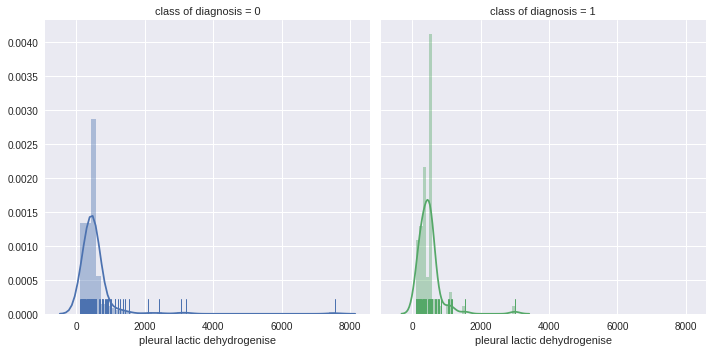

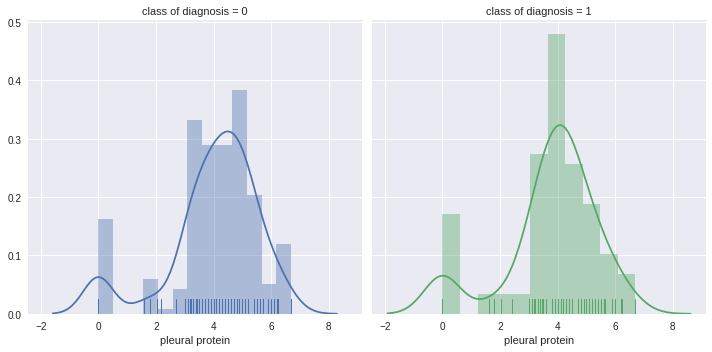

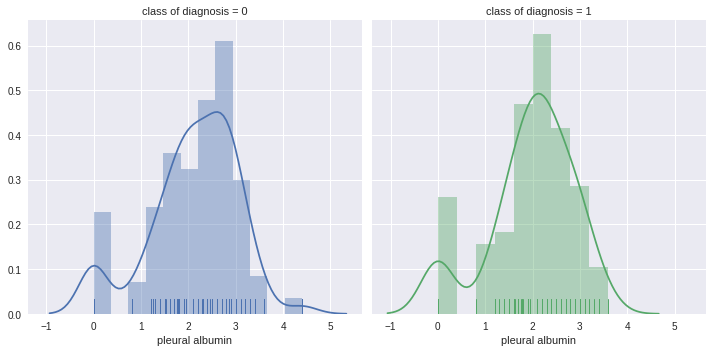

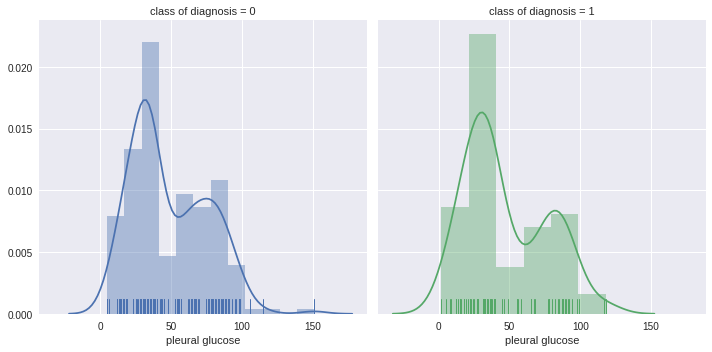

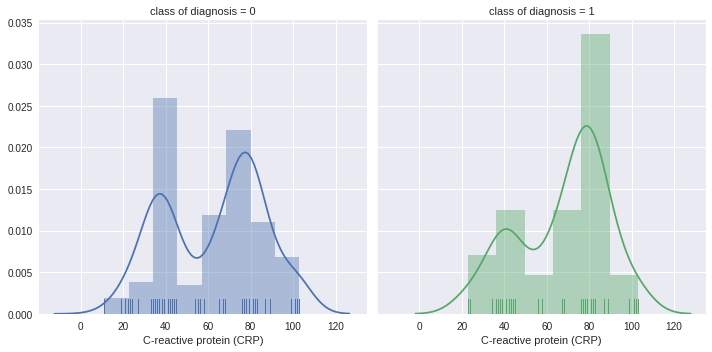

In [6]:
conc = pd.concat([continuous, data['class of diagnosis']], axis=1)
for col in continuous:
    g = sns.FacetGrid(
        size=5, data=conc,
        col='class of diagnosis',
        hue='class of diagnosis'
    )
    g.map(sns.distplot, col, rug=True, kde=True)

In [7]:
conc.groupby('class of diagnosis').describe().round(decimals=3)

C-reactive protein (CRP)      age  albumin  \
class of diagnosis                                                     
0                  count                   228.000  228.000  228.000   
                   mean                     62.636   55.632    3.283   
                   std                      23.280   11.174    0.665   
                   min                      11.000   19.000    1.500   
                   25%                      39.000   47.750    2.975   
                   50%                      67.000   56.000    3.400   
                   75%                      78.250   63.250    3.700   
                   max                     103.000   85.000    6.900   
1                  count                    96.000   96.000   96.000   
                   mean                     67.875   52.635    3.344   
                   std                      20.774   10.339    0.556   
                   min                      23.000   21.000    1.500   
                   25%                      45.000   46.000    3.000   
                   50%                      77.000   54.000    3.500   
                   75%                      81.000   59.000    3.700   
                   max                     103.000   76.000    5.000   

                          alkaline phosphatise (ALP)  \
class of diagnosis                                     
0                  count                     228.000   
                   mean                       66.811   
                   std                        38.864   
                   min                        41.000   
                   25%                        52.000   
                   50%                        62.000   
                   75%                        66.000   
                   max                       489.000   
1                  count                      96.000   
                   mean                       64.625   
                   std                        23.893   
                   min                        45.000   
                   25%                        52.000   
                   50%                        61.500   
                   75%                        66.000   
                   max                       185.000   

                          blood lactic dehydrogenise (LDH)  cell count (WBC)  \
class of diagnosis                                                             
0                  count                           228.000           228.000   
                   mean                            310.316             9.645   
                   std                             187.047             3.486   
                   min                              55.000             4.000   
                   25%                             151.750             7.000   
                   50%                             246.500             9.000   
                   75%                             472.000            12.000   
                   max                            1128.000            22.000   
1                  count                            96.000            96.000   
                   mean                            305.583             9.354   
                   std                             181.466             2.998   
                   min                             101.000             5.000   
                   25%                             156.000             7.000   
                   50%                             206.500             9.000   
                   75%                             543.250            11.000   
                   max                             698.000            22.000   

                          duration of asbestos exposure  duration of symptoms  \
class of diagnosis                                                              
0                  count                        228.000               228.000   
                   mean             

# Check for correlated variables #

Before we start to calculate the correlation factor of each pair of features, we need to determine which indexes of matrix are redundant (we don't want to check correlation of a feature with itself and we also don't want to have duplicate values [values of correlation of pairs (i,j) and (j,i) are equal]).

In [8]:
redundant_pairs = []

for i in range(0, continuous.shape[1]):
    for j in range(0, i + 1):
        redundant_pairs.append((continuous.columns[i], continuous.columns[j]))

# Select correlated variables #
After we determined indexes that are redundant, we can proceed to display the correlated variables. We use Kendall's Tau correlation coefficient. Correlated observations have high values (up to 1 - then they are identical). Dissimilar observations have low values (down to -1 for fully different). 
In this example we assume that variables are correlated if and only if Kendall's tau correlation coefficient is greater than or equal to 0.35.

In [9]:
corr_threshold = 0.35
corr_pairs = continuous.corr(method='kendall').unstack()

corr_pairs = corr_pairs.drop(labels=redundant_pairs).sort_values(ascending=False)
correlated = corr_pairs[corr_pairs >= corr_threshold]
print(correlated)

pleural protein       pleural albumin                     0.714673
platelet count (PLT)  blood lactic dehydrogenise (LDH)    0.362507
dtype: float64


# One-hot encoding

In [10]:
categoricals_BIN_names = ['gender', 'asbestos exposure', 'cytology',
                          'dyspnoea', 'ache on chest', 'weakness',
                          'performance status', 'hemoglobin (HGB)',
                          'dead or not', 'pleural effusion',
                          'pleural thickness on tomography',
                          'pleural level of acidity (pH)']

categoricals_non_BIN_names = ['city', 'type of MM', 'keep side',
                              'habit of cigarette']

categoricals_names = ['city', 'type of MM', 'keep side', 'habit of cigarette',
                      'gender', 'asbestos exposure', 'diagnosis method',
                      'cytology', 'dyspnoea', 'ache on chest', 'weakness',
                      'performance status', 'hemoglobin (HGB)', 'dead or not',
                      'pleural effusion', 'pleural thickness on tomography',
                      'pleural level of acidity (pH)']

continuous_names = ['age',
                        'duration of asbestos exposure',
                        'duration of symptoms', 'white blood',
                        'cell count (WBC)', 'platelet count (PLT)',
                        'sedimentation', 'blood lactic dehydrogenise (LDH)',
                        'alkaline phosphatise (ALP)', 'total protein',
                        'albumin', 'glucose', 'pleural lactic dehydrogenise',
                        'pleural protein', 'pleural albumin',
                        'pleural glucose', 'C-reactive protein (CRP)']
encoded_non_BIN_names = ['city_0', 'city_1', 'city_2', 'city_3', 'city_4',
                        'city_5', 'city_6', 'city_7', 'city_8',
                        'type of MM_0', 'type of MM_1', 'type of MM_2',
                        'keep side_0', 'keep side_1', 'keep side_2',
                        'habit of cigarette_0', 'habit of cigarette_1',
                        'habit of cigarette_2', 'habit of cigarette_3']
categorical_binary = data[categoricals_BIN_names]
categorical_non_binary = data[categoricals_non_BIN_names]

In [11]:
enc = OneHotEncoder(sparse=False)
onehot_X = enc.fit_transform(categorical_non_binary)

temp = np.hstack((onehot_X, categorical_binary, continuous, np.array(data["class of diagnosis"]).reshape(324,1)))

data_encoded = pd.DataFrame(temp)
encoded_column_names = encoded_non_BIN_names + categoricals_BIN_names + continuous_names + ["class of diagnosis"]

data_encoded.columns = encoded_column_names

# Save data prior to further analysis
Before we start any data manipulation, in order to preserve the original paramteres of samples, we have to save encoded data for future models. We also have to split the data into training and test sets(here in 4:1 ratio). We use seed = 1234, so the results are reproducible.

In [12]:
seed = 1234

train, test = train_test_split(data_encoded, test_size = 0.2, random_state=seed)
train.head()
data_encoded.to_csv('data_encoded.csv', index=False)
test.to_csv('test_data.csv', index=False)
train.to_csv('train_data.csv', index=False)

# Plot correlated variables

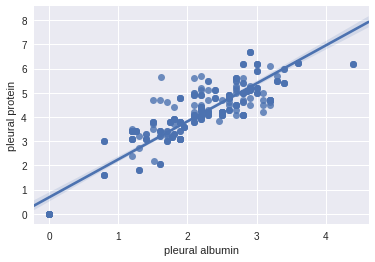

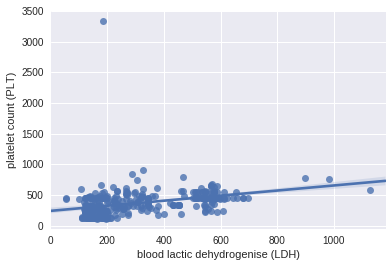

In [13]:
corr = {}

for key in correlated.to_dict():
    if key[0] not in corr:
        corr[key[0]] = [key[1]]
    else:
        corr[key[0]].append(key[1])

for variable in corr:
    for feature in corr[variable]:
        plt.figure()
        sns.regplot(data=continuous, x=feature, y=variable, fit_reg=True)

# Principal component analysis

In order to improve PCA's results, we have to scale the continuous variables.

(324, 19) (324, 12) (324, 17)


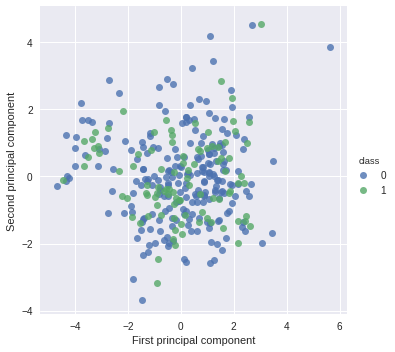

In [14]:
scaler = StandardScaler()
scaler.fit(train[continuous_names])
scaled_cont = scaler.transform(continuous)
print(onehot_X.shape, categorical_binary.shape, scaled_cont.shape)
temp = np.hstack((onehot_X, categorical_binary, scaled_cont))

data_encoded = pd.DataFrame(temp)
data_encoded.columns = encoded_column_names[:-1]

y = data['class of diagnosis']
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(data_encoded)
reduced_dfX = pd.DataFrame(reduced_X, columns=['First principal component',
                                               'Second principal component'])
reduced_dfX['class'] = data['class of diagnosis']
sns.lmplot('First principal component', 'Second principal component',
           data=reduced_dfX, hue='class', fit_reg=False)

# Logistic Regression
We train Logistic Regression model in order to have comparison for further, more complicated methods
To assess LR we use a base model that always chooses the same class of diagnosis


In [15]:
def base_rate_model(X):
    return np.zeros(X.shape[0])

In [16]:
y_base_rate = base_rate_model(test)
X_test = test[test.columns.difference(['class of diagnosis'])]
y_test = test['class of diagnosis']
X_train = train[train.columns.difference(['class of diagnosis'])]
y_train = train['class of diagnosis']
print("Base rate accuracy is {}".format(accuracy_score(y_test, y_base_rate)))

Base rate accuracy is 0.7692307692307693


In [17]:
model = LogisticRegression(penalty='l2', C=1)
model.fit(X_train, y_train)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
print("Logistic regression accuracy = {}".format(accuracy_score(y_test, 
                                                model.predict(X_test))))

Logistic regression accuracy = 0.6615384615384615


In [19]:
print("BASE MODEL")
base_roc_auc = roc_auc_score(y_test, base_rate_model(X_test))
print("Base rate AUC = {}".format(base_roc_auc))
print(classification_report(y_test, base_rate_model(X_test)))
print("LOGISTIC MODEL")
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print("Base rate AUC = {}".format(logit_roc_auc))
print(classification_report(y_test, model.predict(X_test)))

BASE MODEL
Base rate AUC = 0.5
             precision    recall  f1-score   support

        0.0       0.77      1.00      0.87        50
        1.0       0.00      0.00      0.00        15

avg / total       0.59      0.77      0.67        65

LOGISTIC MODEL
Base rate AUC = 0.5233333333333333
             precision    recall  f1-score   support

        0.0       0.78      0.78      0.78        50
        1.0       0.27      0.27      0.27        15

avg / total       0.66      0.66      0.66        65



/home/piotr/miniconda3/envs/MM-diagnosis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

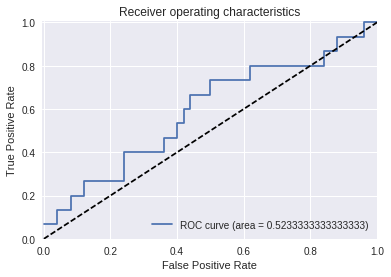

In [21]:
plt.plot(fpr, tpr, label="ROC curve (area = {})".format(logit_roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristics")
plt.legend(loc="lower right")